In [4]:
import networkx as nx
import pandas as pd
import numpy as np

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from Utils import evaluation_measures as ev
import dataframe_image as dfi
import scipy.stats as stats

In [5]:
def label_node(row, name):
   try:
      if labels[labels['id'] == row[name]][['IATA']].iloc[0][0] in list(hubs['Label']):
         return hubs[hubs['Label']==labels[labels['id'] == row[name]][['IATA']].iloc[0][0]]['type'].iloc[0]
   except:
      return 'SPOKE'
   return 'SPOKE'

def label_edge(row):
   l = [row['source_type'], row['target_type']]
   l.sort()
   return  l[0]+ '-' + l[1]

In [101]:
network = 'toy-example'
results = pd.read_csv('../Results/All Backbones/' + network + '.csv')
nodes = pd.read_csv('../Results/All Backbones/'+network+'/original-nodes.csv')
hubs = pd.read_csv('../Results/All Backbones/'+network+'/hubs.csv')
labels = pd.read_csv('airports_labels.csv')

fig_path = '../Results/Figures/Null Models/analysis/'+ network + '/'


node_stats = pd.DataFrame(columns=['Count'], index=['Hub', 'Focus', 'Spoke'])

E = results.shape[0] 
N = len(list(set(set(results['source']) | set(results['target']))))
W = results['weight'].sum()

Hubs_N = nodes[nodes['IATA'].isin(hubs[hubs['type']=='HUB']['Label'].values)].shape[0]
Focus_N = nodes[nodes['IATA'].isin(hubs[hubs['type']=='FOCUS']['Label'].values)].shape[0]
Spokes_N = N - Hubs_N - Focus_N

node_stats['Count']['Hub'] = Hubs_N
node_stats['Count']['Focus'] = Focus_N
node_stats['Count']['Spoke'] = Spokes_N

df_styled = node_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"nodestatus.png")



edge_stats = pd.DataFrame(columns=['Count'], index=['Hub-Hub', 'Hub-Focus', 'Hub-Spoke', 'Focus-Focus', 'Focus-Spoke','Spoke-Spoke'])

results['source_type'] = results.apply (lambda row: label_node(row, 'source'), axis=1)
results['target_type'] = results.apply (lambda row: label_node(row, 'target'), axis=1)
results['edge_type'] = results.apply (lambda row: label_edge(row), axis=1)

hub_hub_E = results[results['edge_type'] == 'HUB-HUB'].shape[0]
hub_focus_E = results[results['edge_type'] == 'FOCUS-HUB'].shape[0]
hub_spoke_E = results[results['edge_type'] == 'HUB-SPOKE'].shape[0]

focus_focus_E = results[results['edge_type'] == 'FOCUS-FOCUS'].shape[0]
focus_spoke_E = results[results['edge_type'] == 'FOCUS-SPOKE'].shape[0]

spoke_spoke_E = results[results['edge_type'] == 'SPOKE-SPOKE'].shape[0]

edge_stats['Count']['Hub-Hub'] = hub_hub_E
edge_stats['Count']['Hub-Focus'] = hub_focus_E
edge_stats['Count']['Hub-Spoke'] = hub_spoke_E

edge_stats['Count']['Focus-Focus'] = focus_focus_E
edge_stats['Count']['Focus-Spoke'] = focus_spoke_E

edge_stats['Count']['Spoke-Spoke'] = spoke_spoke_E

# edge_stats['Max Weight']['Hub-Hub'] = results[results['edge_type'] == 'Hub-Hub']['weight'].max()
# edge_stats['Min Weight']['Hub-Hub'] = results[results['edge_type'] == 'Hub-Hub']['weight'].min()

# edge_stats['Max Weight']['Hub-Spoke'] = results[results['edge_type'] == 'Hub-Spoke']['weight'].max()
# edge_stats['Min Weight']['Hub-Spoke'] = results[results['edge_type'] == 'Hub-Spoke']['weight'].min()

# edge_stats['Max Weight']['Spoke-Spoke'] = results[results['edge_type'] == 'Spoke-Spoke']['weight'].max()
# edge_stats['Min Weight']['Spoke-Spoke'] = results[results['edge_type'] == 'Spoke-Spoke']['weight'].min()

df_styled = edge_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"edge_stats.png")


weight_stats = pd.DataFrame(columns=['Count'], index=['Hub-Hub', 'Hub-Focus', 'Hub-Spoke', 'Focus-Focus', 'Focus-Spoke','Spoke-Spoke'])

hub_hub_W = results[results['edge_type'] == 'HUB-HUB']['weight'].sum()
hub_focus_W = results[results['edge_type'] == 'FOCUS-HUB']['weight'].sum()
hub_spoke_W = results[results['edge_type'] == 'HUB-SPOKE']['weight'].sum()

focus_focus_W = results[results['edge_type'] == 'FOCUS-FOCUS']['weight'].sum()
focus_spoke_W = results[results['edge_type'] == 'FOCUS-SPOKE']['weight'].sum()

spoke_spoke_W = results[results['edge_type'] == 'SPOKE-SPOKE']['weight'].sum()

weight_stats['Count']['Hub-Hub'] = hub_hub_W
weight_stats['Count']['Hub-Focus'] = hub_focus_W
weight_stats['Count']['Hub-Spoke'] = hub_spoke_W

weight_stats['Count']['Focus-Focus'] = focus_focus_W
weight_stats['Count']['Focus-Spoke'] = focus_spoke_W

weight_stats['Count']['Spoke-Spoke'] = spoke_spoke_W


df_styled = weight_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"weight_stats.png")

names = ['global_score', 'df_alpha', 'pf_alpha', 'gloss_alpha','lans_alpha', 'mlf_score','nc_alpha', 'ecm_alpha']

nodes_analysis = pd.DataFrame(columns=['% Nodes', '% Hubs', '% Focus', '% Spokes'], index=names)
edge_analysis = pd.DataFrame(columns=['% Hub-Hub', '% Hub-Focus', '% Hub-Spoke', '% Focus-Focus', '% Focus-Spoke', '% Spoke-Spoke'], index=names)
weight_analysis = pd.DataFrame(columns=['% Weights','% Hub-Hub', '% Hub-Focus', '% Hub-Spoke', '% Focus-Focus', '% Focus-Spoke', '% Spoke-Spoke'], index=names)
component_analysis = pd.DataFrame()
#edge_component_analysis = pd.DataFrame()


for name in names:
    backbone_edges = pd.read_csv('../Results/All Backbones/'+network+'/' + name + '-edges.csv')
    backbone_nodes = pd.read_csv('../Results/All Backbones/'+network+'/'+ name + '-nodes.csv')

    backbone_nodes['type'] = backbone_nodes.apply (lambda row: label_node(row, 'id'), axis=1)

    nodes_analysis['% Nodes'][name] = backbone_nodes.shape[0]*100/N
    nodes_analysis['% Hubs'][name] = backbone_nodes[backbone_nodes['type'] == 'HUB'].shape[0]*100/Hubs_N
    nodes_analysis['% Focus'][name] = backbone_nodes[backbone_nodes['type'] == 'FOCUS'].shape[0]*100/Focus_N
    nodes_analysis['% Spokes'][name] = backbone_nodes[backbone_nodes['type'] == 'SPOKE'].shape[0]*100/Spokes_N

    backbone_edges['source_type'] = backbone_edges.apply (lambda row: label_node(row, 'source'), axis=1)
    backbone_edges['target_type'] = backbone_edges.apply (lambda row: label_node(row, 'target'), axis=1)
    backbone_edges['edge_type'] = backbone_edges.apply (lambda row: label_edge(row), axis=1)


    try:
        edge_analysis['% Hub-Hub'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-HUB'].shape[0]*100/hub_hub_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Hub'][name] = 0

    try:
        edge_analysis['% Hub-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-HUB'].shape[0]*100/hub_focus_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Focus'][name] = 0

    try:
        edge_analysis['% Hub-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-SPOKE'].shape[0]*100/hub_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Spoke'][name] = 0

        
    try:
        edge_analysis['% Focus-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-FOCUS'].shape[0]*100/focus_focus_E
    except ZeroDivisionError:
        edge_analysis['% Focus-Focus'][name] = 0

    try:
        edge_analysis['% Focus-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-SPOKE'].shape[0]*100/focus_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Focus-Spoke'][name] = 0  

    try:
        edge_analysis['% Spoke-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'SPOKE-SPOKE'].shape[0]*100/spoke_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Spoke-Spoke'][name] = 0   


    weight_analysis['% Weights'][name] = backbone_edges['weight'].sum()*100/W
    weight_analysis['% Hub-Hub'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-HUB']['weight'].sum()*100/hub_hub_W
    weight_analysis['% Hub-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-HUB']['weight'].sum()*100/hub_focus_W
    weight_analysis['% Hub-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-SPOKE']['weight'].sum()*100/hub_spoke_W

    weight_analysis['% Focus-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-FOCUS']['weight'].sum()*100/focus_focus_W
    weight_analysis['% Focus-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-SPOKE']['weight'].sum()*100/focus_spoke_W

    weight_analysis['% Spoke-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'SPOKE-SPOKE']['weight'].sum()*100/spoke_spoke_W

    b = nx.from_pandas_edgelist(backbone_edges)
    unique_elements, counts_elements = np.unique(np.sort(-np.array(ev.get_connected_components_sizes(b))*100/len(b)), return_counts=True)
    vals = [str(-round(unique_elements[i],2)) + "(" + str(counts_elements[i]) +")" for i in range(len(unique_elements))]
    component_analysis = pd.concat([component_analysis.T, pd.DataFrame(vals).T]).T
    #edge_component_analysis = pd.concat([edge_component_analysis.T, pd.DataFrame(-np.sort(-np.array(ev.get_connected_components_sizes_wrt_edges(b))*100/len(b.edges()))).T]).T

component_analysis = component_analysis.T
component_analysis.index = names

# edge_component_analysis = edge_component_analysis.T
# edge_component_analysis.index = names

df_styled = nodes_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"nodes_analysis.png")

df_styled = edge_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"edge_analysis.png")

df_styled = weight_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"weight_analysis.png")

df_styled = component_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"component_analysis.png")

# df_styled = edge_component_analysis.style.background_gradient() #adding a gradient based on values in cell
# dfi.export(df_styled,fig_path+"edge_component_analysis.png")




objc[14119]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa442d2318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/101.0.4951.64/Libraries/libGLESv2.dylib (0x10e569218). One of the two will be used. Which one is undefined.
[0525/135715.951989:INFO:headless_shell.cc(660)] Written to file /var/folders/y_/k_c4gj5x3rv1kmhprsdpc3lm0000gn/T/tmpe2cf_i2e/temp.png.
objc[14136]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa442d2318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/101.0.4951.64/Libraries/libGLESv2.dylib (0x111ff9218). One of the two will be used. Which one is undefined.
[0525/135718.817700:INFO:headless_shell.cc(6

In [7]:
toy_edge_analysis = edge_analysis
toy_node_analysis = nodes_analysis
toy_weight_analysis = weight_analysis

In [8]:
network = 'north_america'
results = pd.read_csv('../Results/All Backbones/' + network + '.csv')
nodes = pd.read_csv('../Results/All Backbones/'+network+'/original-nodes.csv')
hubs = pd.read_csv('../Results/All Backbones/'+network+'/hubs.csv')
labels = pd.read_csv('airports_labels.csv')

fig_path = '../Results/Figures/Null Models/analysis/'+ network + '/'


node_stats = pd.DataFrame(columns=['Count'], index=['Hub', 'Focus', 'Spoke'])

E = results.shape[0] 
N = len(list(set(set(results['source']) | set(results['target']))))
W = results['weight'].sum()

Hubs_N = nodes[nodes['IATA'].isin(hubs[hubs['type']=='HUB']['Label'].values)].shape[0]
Focus_N = nodes[nodes['IATA'].isin(hubs[hubs['type']=='FOCUS']['Label'].values)].shape[0]
Spokes_N = N - Hubs_N - Focus_N

node_stats['Count']['Hub'] = Hubs_N
node_stats['Count']['Focus'] = Focus_N
node_stats['Count']['Spoke'] = Spokes_N

df_styled = node_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"nodestatus.png")



edge_stats = pd.DataFrame(columns=['Count'], index=['Hub-Hub', 'Hub-Focus', 'Hub-Spoke', 'Focus-Focus', 'Focus-Spoke','Spoke-Spoke'])

results['source_type'] = results.apply (lambda row: label_node(row, 'source'), axis=1)
results['target_type'] = results.apply (lambda row: label_node(row, 'target'), axis=1)
results['edge_type'] = results.apply (lambda row: label_edge(row), axis=1)

hub_hub_E = results[results['edge_type'] == 'HUB-HUB'].shape[0]
hub_focus_E = results[results['edge_type'] == 'FOCUS-HUB'].shape[0]
hub_spoke_E = results[results['edge_type'] == 'HUB-SPOKE'].shape[0]

focus_focus_E = results[results['edge_type'] == 'FOCUS-FOCUS'].shape[0]
focus_spoke_E = results[results['edge_type'] == 'FOCUS-SPOKE'].shape[0]

spoke_spoke_E = results[results['edge_type'] == 'SPOKE-SPOKE'].shape[0]

edge_stats['Count']['Hub-Hub'] = hub_hub_E
edge_stats['Count']['Hub-Focus'] = hub_focus_E
edge_stats['Count']['Hub-Spoke'] = hub_spoke_E

edge_stats['Count']['Focus-Focus'] = focus_focus_E
edge_stats['Count']['Focus-Spoke'] = focus_spoke_E

edge_stats['Count']['Spoke-Spoke'] = spoke_spoke_E

# edge_stats['Max Weight']['Hub-Hub'] = results[results['edge_type'] == 'Hub-Hub']['weight'].max()
# edge_stats['Min Weight']['Hub-Hub'] = results[results['edge_type'] == 'Hub-Hub']['weight'].min()

# edge_stats['Max Weight']['Hub-Spoke'] = results[results['edge_type'] == 'Hub-Spoke']['weight'].max()
# edge_stats['Min Weight']['Hub-Spoke'] = results[results['edge_type'] == 'Hub-Spoke']['weight'].min()

# edge_stats['Max Weight']['Spoke-Spoke'] = results[results['edge_type'] == 'Spoke-Spoke']['weight'].max()
# edge_stats['Min Weight']['Spoke-Spoke'] = results[results['edge_type'] == 'Spoke-Spoke']['weight'].min()

df_styled = edge_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"edge_stats.png")


weight_stats = pd.DataFrame(columns=['Count'], index=['Hub-Hub', 'Hub-Focus', 'Hub-Spoke', 'Focus-Focus', 'Focus-Spoke','Spoke-Spoke'])

hub_hub_W = results[results['edge_type'] == 'HUB-HUB']['weight'].sum()
hub_focus_W = results[results['edge_type'] == 'FOCUS-HUB']['weight'].sum()
hub_spoke_W = results[results['edge_type'] == 'HUB-SPOKE']['weight'].sum()

focus_focus_W = results[results['edge_type'] == 'FOCUS-FOCUS']['weight'].sum()
focus_spoke_W = results[results['edge_type'] == 'FOCUS-SPOKE']['weight'].sum()

spoke_spoke_W = results[results['edge_type'] == 'SPOKE-SPOKE']['weight'].sum()

weight_stats['Count']['Hub-Hub'] = hub_hub_W
weight_stats['Count']['Hub-Focus'] = hub_focus_W
weight_stats['Count']['Hub-Spoke'] = hub_spoke_W

weight_stats['Count']['Focus-Focus'] = focus_focus_W
weight_stats['Count']['Focus-Spoke'] = focus_spoke_W

weight_stats['Count']['Spoke-Spoke'] = spoke_spoke_W


df_styled = weight_stats.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"weight_stats.png")

names = ['global_score', 'df_alpha', 'pf_alpha', 'gloss_alpha','lans_alpha', 'mlf_score','nc_alpha', 'ecm_alpha']

nodes_analysis = pd.DataFrame(columns=['% Nodes', '% Hubs', '% Focus', '% Spokes'], index=names)
edge_analysis = pd.DataFrame(columns=['% Hub-Hub', '% Hub-Focus', '% Hub-Spoke', '% Focus-Focus', '% Focus-Spoke', '% Spoke-Spoke'], index=names)
weight_analysis = pd.DataFrame(columns=['% Weights','% Hub-Hub', '% Hub-Focus', '% Hub-Spoke', '% Focus-Focus', '% Focus-Spoke', '% Spoke-Spoke'], index=names)
component_analysis = pd.DataFrame()
#edge_component_analysis = pd.DataFrame()


for name in names:
    backbone_edges = pd.read_csv('../Results/All Backbones/'+network+'/' + name + '-edges.csv')
    backbone_nodes = pd.read_csv('../Results/All Backbones/'+network+'/'+ name + '-nodes.csv')

    backbone_nodes['type'] = backbone_nodes.apply (lambda row: label_node(row, 'id'), axis=1)

    nodes_analysis['% Nodes'][name] = backbone_nodes.shape[0]*100/N
    nodes_analysis['% Hubs'][name] = backbone_nodes[backbone_nodes['type'] == 'HUB'].shape[0]*100/Hubs_N
    nodes_analysis['% Focus'][name] = backbone_nodes[backbone_nodes['type'] == 'FOCUS'].shape[0]*100/Focus_N
    nodes_analysis['% Spokes'][name] = backbone_nodes[backbone_nodes['type'] == 'SPOKE'].shape[0]*100/Spokes_N

    backbone_edges['source_type'] = backbone_edges.apply (lambda row: label_node(row, 'source'), axis=1)
    backbone_edges['target_type'] = backbone_edges.apply (lambda row: label_node(row, 'target'), axis=1)
    backbone_edges['edge_type'] = backbone_edges.apply (lambda row: label_edge(row), axis=1)


    try:
        edge_analysis['% Hub-Hub'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-HUB'].shape[0]*100/hub_hub_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Hub'][name] = 0

    try:
        edge_analysis['% Hub-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-HUB'].shape[0]*100/hub_focus_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Focus'][name] = 0

    try:
        edge_analysis['% Hub-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-SPOKE'].shape[0]*100/hub_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Hub-Spoke'][name] = 0

        
    try:
        edge_analysis['% Focus-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-FOCUS'].shape[0]*100/focus_focus_E
    except ZeroDivisionError:
        edge_analysis['% Focus-Focus'][name] = 0

    try:
        edge_analysis['% Focus-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-SPOKE'].shape[0]*100/focus_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Focus-Spoke'][name] = 0  

    try:
        edge_analysis['% Spoke-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'SPOKE-SPOKE'].shape[0]*100/spoke_spoke_E
    except ZeroDivisionError:
        edge_analysis['% Spoke-Spoke'][name] = 0   


    weight_analysis['% Weights'][name] = backbone_edges['weight'].sum()*100/W
    weight_analysis['% Hub-Hub'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-HUB']['weight'].sum()*100/hub_hub_W
    weight_analysis['% Hub-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-HUB']['weight'].sum()*100/hub_focus_W
    weight_analysis['% Hub-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'HUB-SPOKE']['weight'].sum()*100/hub_spoke_W

    weight_analysis['% Focus-Focus'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-FOCUS']['weight'].sum()*100/focus_focus_W
    weight_analysis['% Focus-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'FOCUS-SPOKE']['weight'].sum()*100/focus_spoke_W

    weight_analysis['% Spoke-Spoke'][name] = backbone_edges[backbone_edges['edge_type'] == 'SPOKE-SPOKE']['weight'].sum()*100/spoke_spoke_W

    b = nx.from_pandas_edgelist(backbone_edges)
    unique_elements, counts_elements = np.unique(np.sort(-np.array(ev.get_connected_components_sizes(b))*100/len(b)), return_counts=True)
    vals = [str(-round(unique_elements[i],2)) + "(" + str(counts_elements[i]) +")" for i in range(len(unique_elements))]
    component_analysis = pd.concat([component_analysis.T, pd.DataFrame(vals).T]).T
    #edge_component_analysis = pd.concat([edge_component_analysis.T, pd.DataFrame(-np.sort(-np.array(ev.get_connected_components_sizes_wrt_edges(b))*100/len(b.edges()))).T]).T

component_analysis = component_analysis.T
component_analysis.index = names

# edge_component_analysis = edge_component_analysis.T
# edge_component_analysis.index = names

df_styled = nodes_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"nodes_analysis.png")

df_styled = edge_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"edge_analysis.png")

df_styled = weight_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"weight_analysis.png")

df_styled = component_analysis.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,fig_path+"component_analysis.png")

# df_styled = edge_component_analysis.style.background_gradient() #adding a gradient based on values in cell
# dfi.export(df_styled,fig_path+"edge_component_analysis.png")




objc[10922]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa442d2318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/101.0.4951.64/Libraries/libGLESv2.dylib (0x112873218). One of the two will be used. Which one is undefined.
[0524/211521.846816:INFO:headless_shell.cc(660)] Written to file /var/folders/y_/k_c4gj5x3rv1kmhprsdpc3lm0000gn/T/tmp6t2v9k7b/temp.png.
objc[10938]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa442d2318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/101.0.4951.64/Libraries/libGLESv2.dylib (0x10ee99218). One of the two will be used. Which one is undefined.
[0524/211528.158292:INFO:headless_shell.cc(6

In [9]:
north_america_edge_analysis = edge_analysis
north_america_node_analysis = nodes_analysis
north_america_weight_analysis = weight_analysis

In [85]:
node_analysis_corr = pd.DataFrame(columns=north_america_node_analysis.columns, index=['RBO', 'Kendall', 'Spearman'])
for col in north_america_node_analysis.columns:
    s1 = north_america_node_analysis[col].sort_values(ascending=False).index
    s2 = toy_node_analysis[col].sort_values(ascending=False).index
    node_analysis_corr[col]['Kendall'] = stats.kendalltau(list(s1), list(s2))[0]
    node_analysis_corr[col]['RBO'] = ev.get_rbo(list(s1), list(s2), 0.98)
    node_analysis_corr[col]['Spearman'] = stats.spearmanr(list(s1), list(s2))[0]

In [86]:
edge_analysis_corr = pd.DataFrame(columns=north_america_edge_analysis.columns, index=['RBO', 'Kendall', 'Spearman'])
for col in north_america_edge_analysis.columns:
    s1 = north_america_edge_analysis[col].sort_values(ascending=False).index
    s2 = toy_edge_analysis[col].sort_values(ascending=False).index
    edge_analysis_corr[col]['Kendall'] = stats.kendalltau(list(s1), list(s2))[0]
    edge_analysis_corr[col]['RBO'] = ev.get_rbo(list(s1), list(s2), 0.98)
    edge_analysis_corr[col]['Spearman'] = stats.spearmanr(list(s1), list(s2))[0]

In [87]:
weight_analysis_corr = pd.DataFrame(columns=north_america_weight_analysis.columns, index=['RBO', 'Kendall', 'Spearman'])
for col in north_america_weight_analysis.columns:
    s1 = north_america_weight_analysis[col].sort_values(ascending=False).index
    s2 = toy_weight_analysis[col].sort_values(ascending=False).index
    weight_analysis_corr[col]['Kendall'] = stats.kendalltau(list(s1), list(s2))[0]
    weight_analysis_corr[col]['RBO'] = ev.get_rbo(list(s1), list(s2), 0.98)
    weight_analysis_corr[col]['Spearman'] = stats.spearmanr(list(s1), list(s2))[0]

In [88]:
node_analysis_corr

,% Nodes,% Hubs,% Focus,% Spokes
RBO,0.966061,0.914151,0.943155,0.979658
Kendall,-0.428571,-0.214286,0.214286,0.071429
Spearman,-0.5,-0.285714,0.190476,0.095238


In [89]:
edge_analysis_corr

,% Hub-Hub,% Hub-Focus,% Hub-Spoke,% Focus-Focus,% Focus-Spoke,% Spoke-Spoke
RBO,0.948999,0.984364,0.952047,0.943993,0.931662,0.928949
Kendall,0.0,-0.285714,-0.285714,0.0,-0.428571,0.5
Spearman,0.047619,-0.380952,-0.428571,0.047619,-0.571429,0.666667


In [90]:
weight_analysis_corr

,% Weights,% Hub-Hub,% Hub-Focus,% Hub-Spoke,% Focus-Focus,% Focus-Spoke,% Spoke-Spoke
RBO,0.990766,0.990766,0.986061,0.941762,0.943993,0.933655,0.912155
Kendall,0.214286,0.214286,0.642857,-0.142857,0.071429,0.071429,-0.571429
Spearman,0.261905,0.261905,0.785714,-0.071429,0.190476,0.071429,-0.714286


In [13]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
backbone_edges[backbone_edges['edge_type'] == type]

,source,target,weight,ecm_alpha,source_type,target_type,edge_type
174,132,591,4997,0.000746,HUB,HUB,HUB-HUB


ValueError: not enough values to unpack (expected 2, got 0)

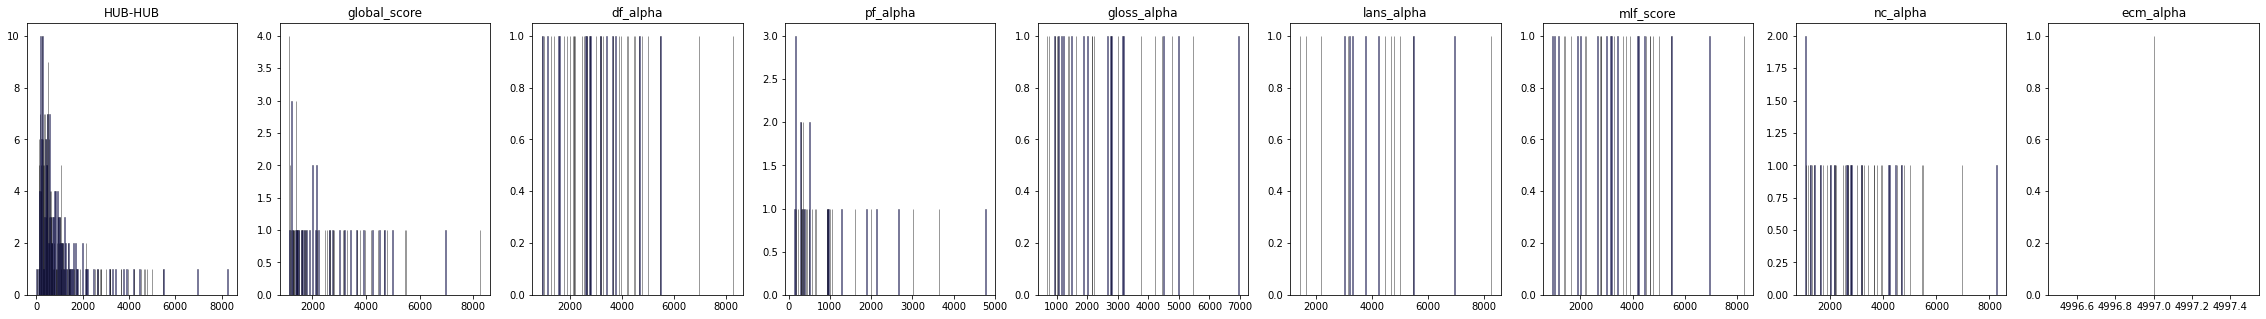

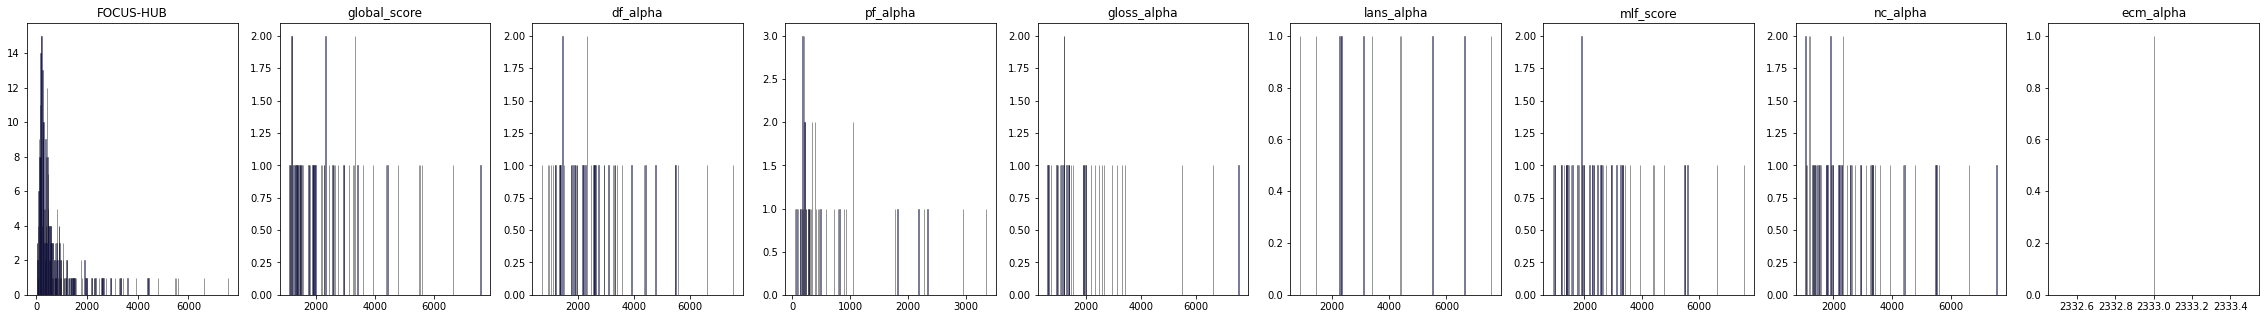

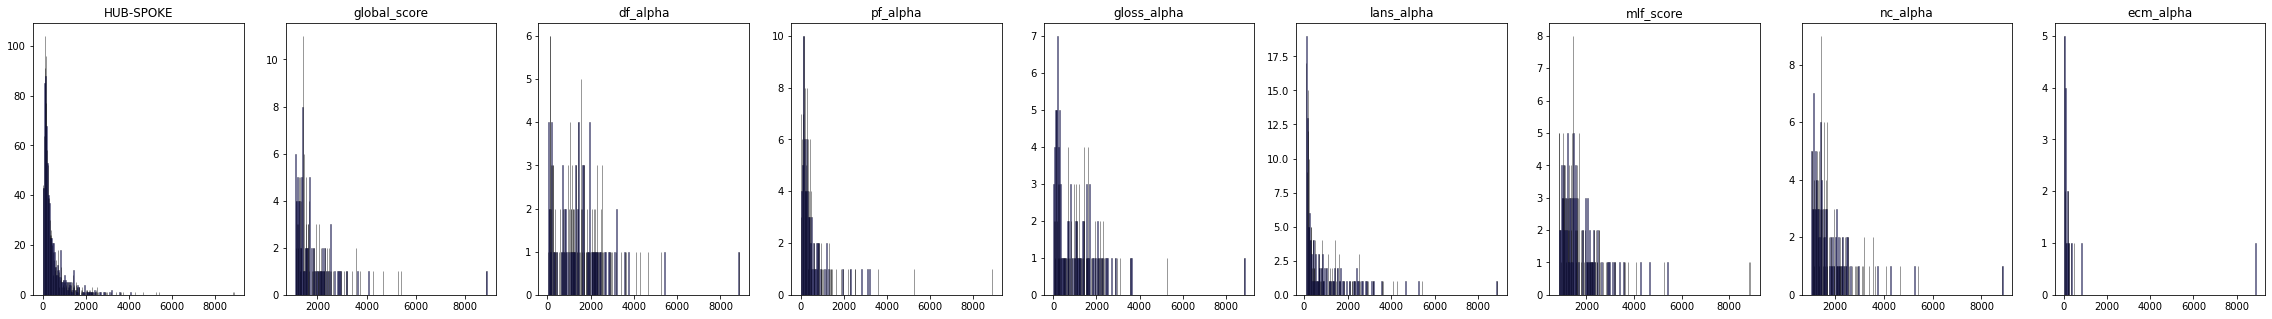

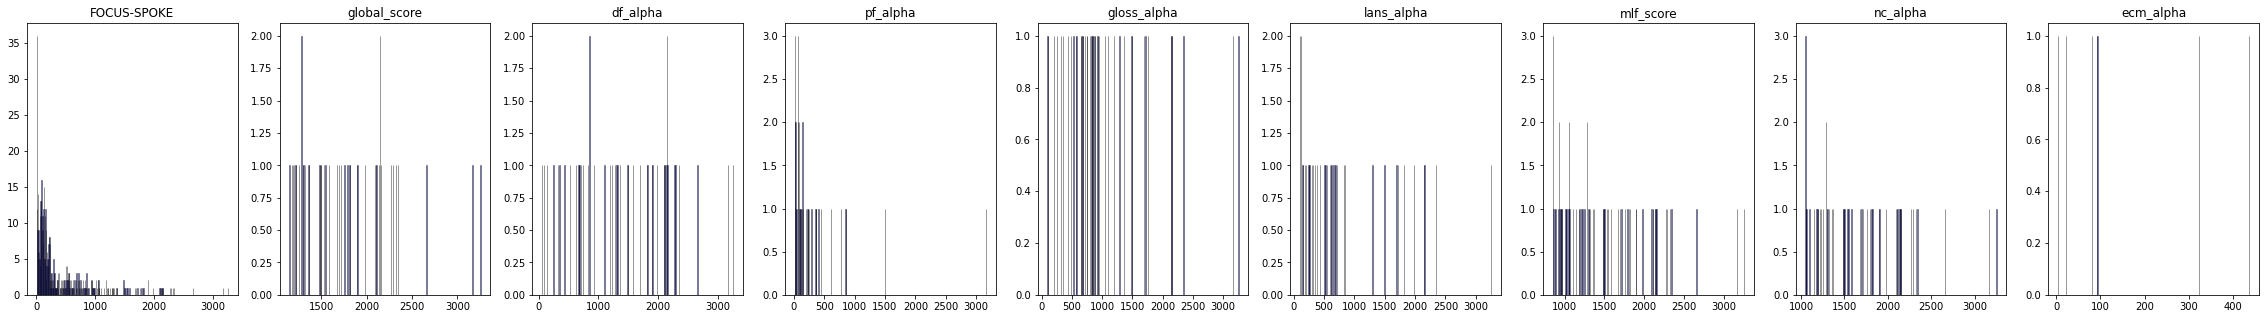

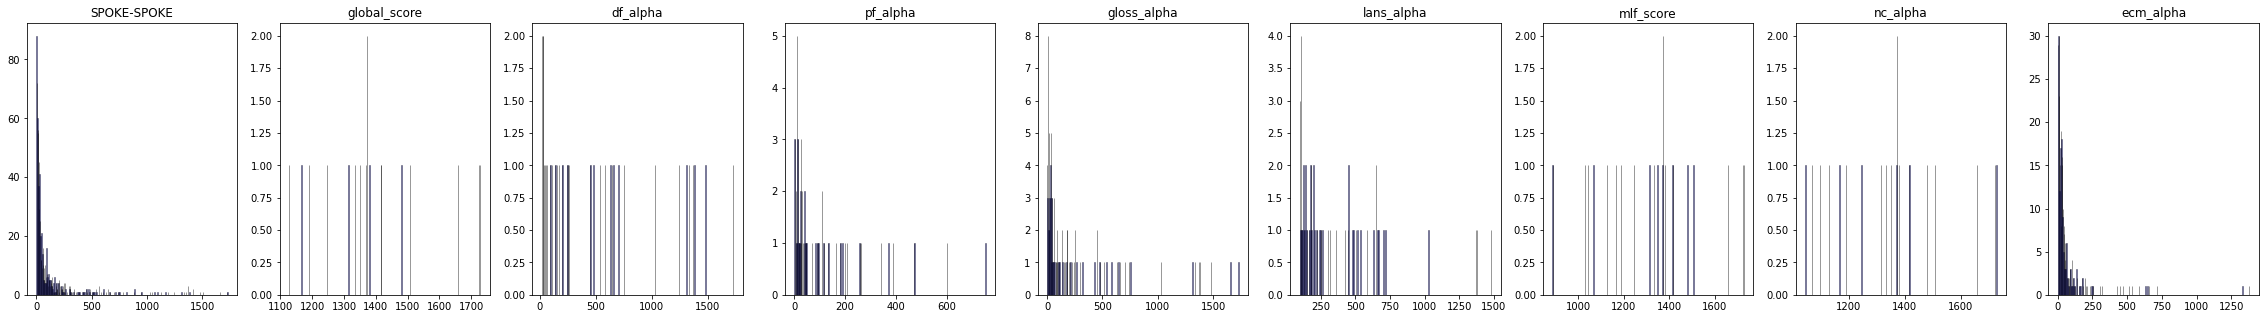

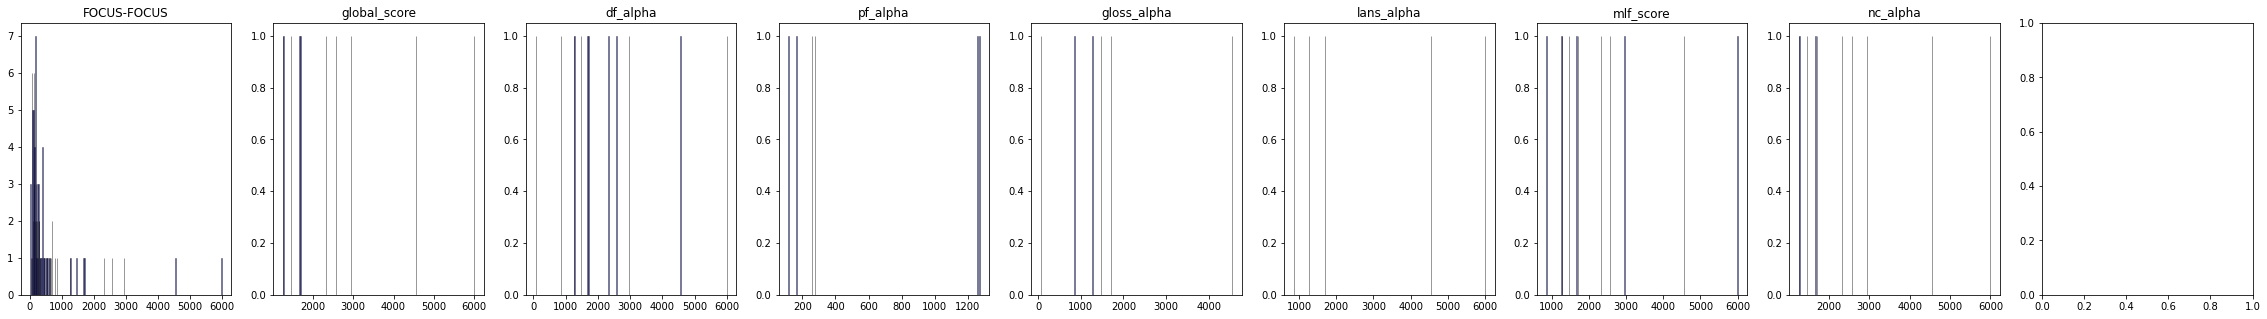

In [77]:
network = 'north_america'
edge_types = ['HUB-HUB', 'FOCUS-HUB', 'HUB-SPOKE', 'FOCUS-SPOKE', 'SPOKE-SPOKE', 'FOCUS-FOCUS']

col = 9
row = 1
for type in edge_types:
    fig, axs = plt.subplots(row, col, figsize=(40,5))
    i=0

    values = results[results['edge_type'] == type]['weight'].to_list()
    counts = Counter(values)   

    x, y = zip(*counts.items())

    sns.distplot(values, hist=True, kde=False, 
             bins=int(500), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axs[i%col]) #ax=axs[int(i/col), i%col])  
    

    ax=axs[i%col].set_title(type) #ax=axs[int(i/col), i%col])
    for i, name in enumerate(names):
        i = i+1
        #ax=axs[i%col]
        backbone_edges = pd.read_csv('../Results/All Backbones/'+network+'/' + name + '-edges.csv')
        backbone_nodes = pd.read_csv('../Results/All Backbones/'+network+'/'+ name + '-nodes.csv')

        backbone_nodes['type'] = backbone_nodes.apply (lambda row: label_node(row, 'id'), axis=1)

    
        backbone_edges['source_type'] = backbone_edges.apply (lambda row: label_node(row, 'source'), axis=1)
        backbone_edges['target_type'] = backbone_edges.apply (lambda row: label_node(row, 'target'), axis=1)
        backbone_edges['edge_type'] = backbone_edges.apply (lambda row: label_edge(row), axis=1)


        values = backbone_edges[backbone_edges['edge_type'] == type]['weight'].to_list()
        counts = Counter(values)   

        x, y = zip(*counts.items())

        sns.distplot(values, hist=True, kde=False, 
                bins=int(500), color = 'blue',
                hist_kws={'edgecolor':'black'}, ax=axs[i%col]) #ax=axs[int(i/col), i%col])
        ax=axs[i%col].set_title(name) #ax=axs[int(i/col), i%col])
    # plt.figure(1)   
                                                                                                                                                                                                                                                        
    # prep axes                                                                                                                      
    #plt.xlabel('weight')                                                                                                             
                                                                                                            
    #plt.ylabel('Frequency')                                                                                                                                                                                                                         
    # plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                        # do plot                                                                                                                        
     
    #plt.title(type)                                                                                              
    #plt.show()
    # break

/Users/ali/opt/anaconda3/envs/python3.7.7-env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: not enough values to unpack (expected 2, got 0)

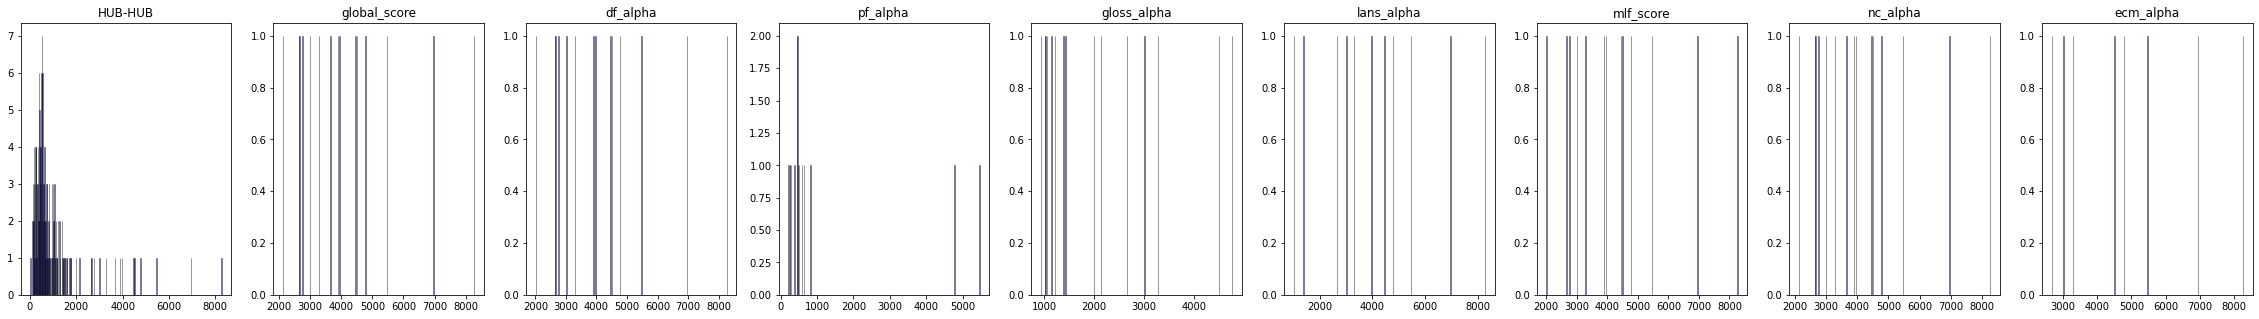

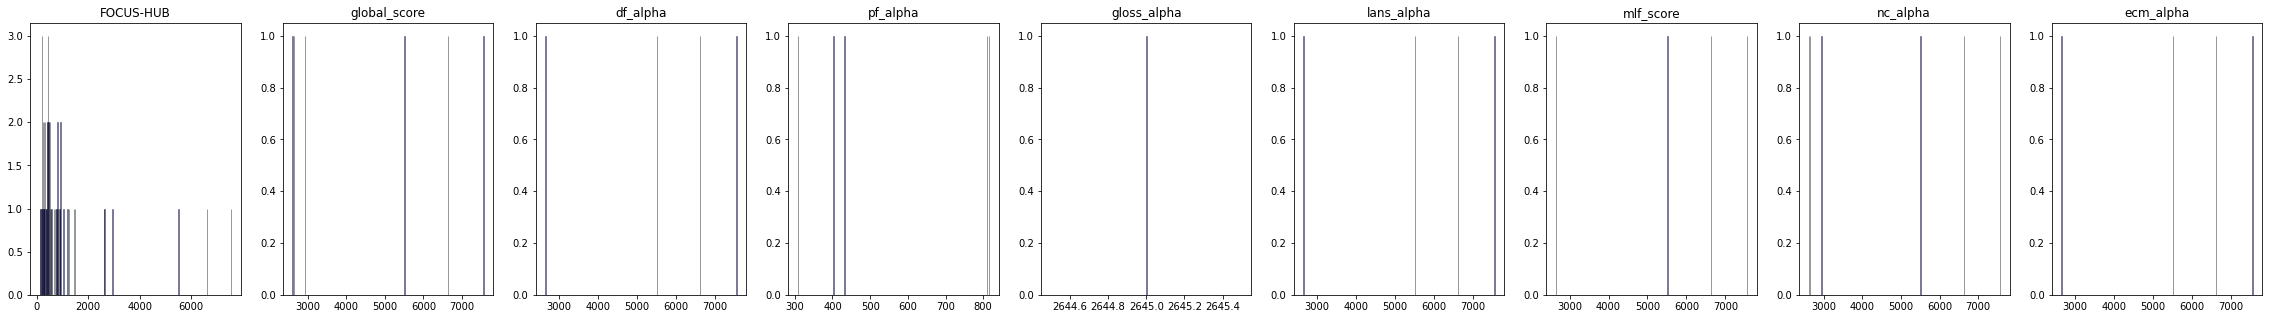

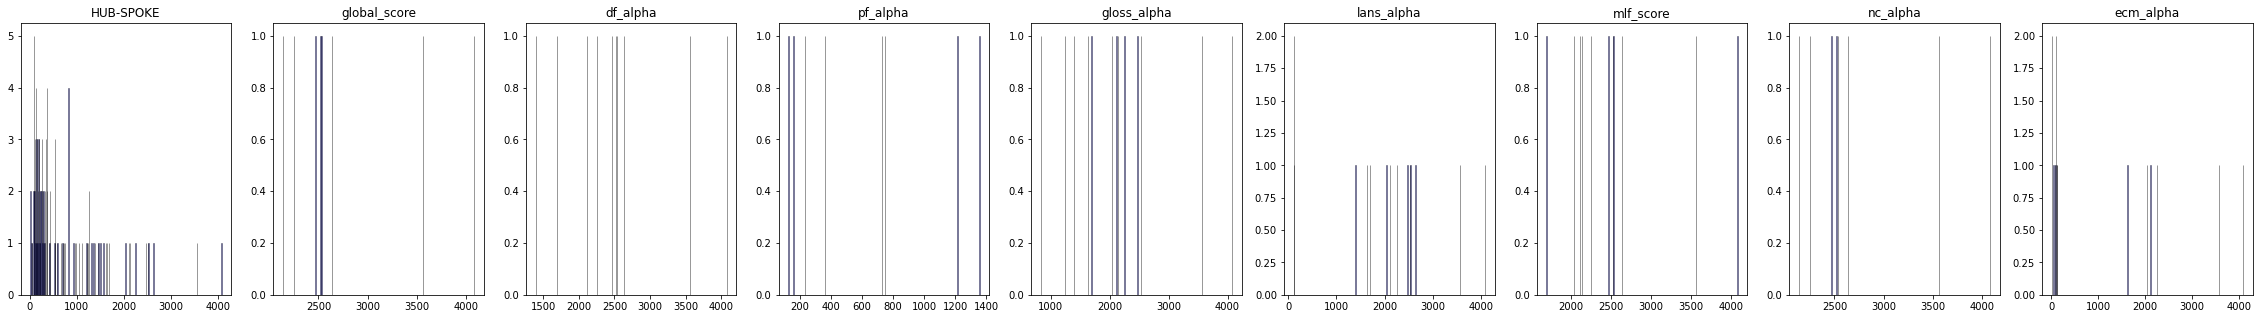

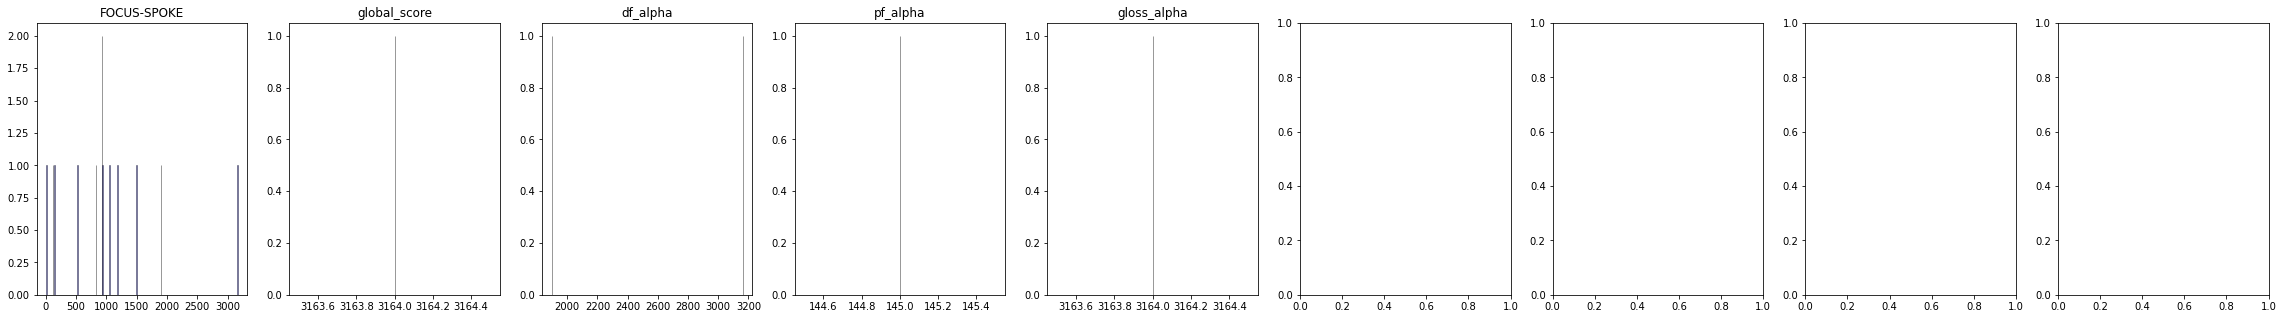

In [102]:
network = 'toy-example'
edge_types = ['HUB-HUB', 'FOCUS-HUB', 'HUB-SPOKE', 'FOCUS-SPOKE']

col = 9
row = 1
for type in edge_types:
    fig, axs = plt.subplots(row, col, figsize=(40,5))
    i=0

    values = results[results['edge_type'] == type]['weight'].to_list()
    counts = Counter(values)   

    x, y = zip(*counts.items())

    sns.distplot(values, hist=True, kde=False, 
             bins=int(500), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axs[i%col]) #ax=axs[int(i/col), i%col])  
    

    ax=axs[i%col].set_title(type) #ax=axs[int(i/col), i%col])
    for i, name in enumerate(names):
        i = i+1
        #ax=axs[i%col]
        backbone_edges = pd.read_csv('../Results/All Backbones/'+network+'/' + name + '-edges.csv')
        backbone_nodes = pd.read_csv('../Results/All Backbones/'+network+'/'+ name + '-nodes.csv')

        backbone_nodes['type'] = backbone_nodes.apply (lambda row: label_node(row, 'id'), axis=1)

    
        backbone_edges['source_type'] = backbone_edges.apply (lambda row: label_node(row, 'source'), axis=1)
        backbone_edges['target_type'] = backbone_edges.apply (lambda row: label_node(row, 'target'), axis=1)
        backbone_edges['edge_type'] = backbone_edges.apply (lambda row: label_edge(row), axis=1)


        values = backbone_edges[backbone_edges['edge_type'] == type]['weight'].to_list()
        counts = Counter(values)   

        x, y = zip(*counts.items())

        sns.distplot(values, hist=True, kde=False, 
                bins=int(500), color = 'blue',
                hist_kws={'edgecolor':'black'}, ax=axs[i%col]) #ax=axs[int(i/col), i%col])
        ax=axs[i%col].set_title(name) #ax=axs[int(i/col), i%col])
    # plt.figure(1)   
                                                                                                                                                                                                                                                        
    # prep axes                                                                                                                      
    #plt.xlabel('weight')                                                                                                             
                                                                                                            
    #plt.ylabel('Frequency')                                                                                                                                                                                                                         
    # plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                        # do plot                                                                                                                        
     
    #plt.title(type)                                                                                              
    #plt.show()
    # break

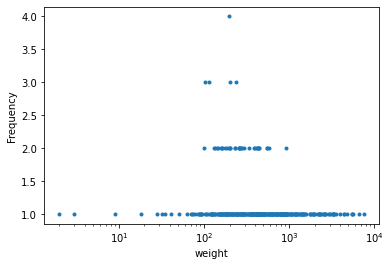

In [138]:
hub_weights = results[results['edge_type'] == 'FOCUS-FOCUS']['weight'].to_list()
counts = Counter(hub_weights)   
# dist = dict(zip(counts.keys(), np.array(list(counts.values()))/len(hub_weights)))
# x = dist.keys()
# y = dist.values()

x, y = zip(*counts.items())
plt.figure(1)   
                                                                                                                                                                                                                                                      
# prep axes                                                                                                                      
plt.xlabel('weight')                                                                                                             
plt.xscale('log')                                                                                                                
# plt.xlim(1, max(x)+1)  
                                                                                                           
plt.ylabel('Frequency')                                                                                                                                                                                                                         
# plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                     # do plot                                                                                                                        
plt.scatter(x, y, marker='.')                                                                                                    
plt.show()

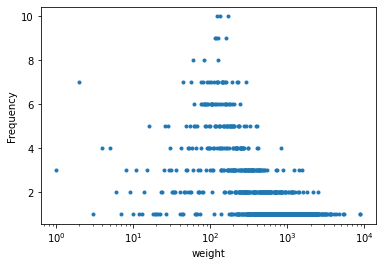

In [139]:
hub_weights = results[results['edge_type'] == 'HUB-SPOKE']['weight'].to_list()
counts = Counter(hub_weights)   
# dist = dict(zip(counts.keys(), np.array(list(counts.values()))/len(hub_weights)))
# x = dist.keys()
# y = dist.values()

x, y = zip(*counts.items())
plt.figure(1)   
                                                                                                                                                                                                                                                      
# prep axes                                                                                                                      
plt.xlabel('weight')                                                                                                             
plt.xscale('log')                                                                                                                
# plt.xlim(1, max(x)+1)  
                                                                                                           
plt.ylabel('Frequency')                                                                                                                                                                                                                         
# plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                     # do plot                                                                                                                        
plt.scatter(x, y, marker='.')                                                                                                    
plt.show()

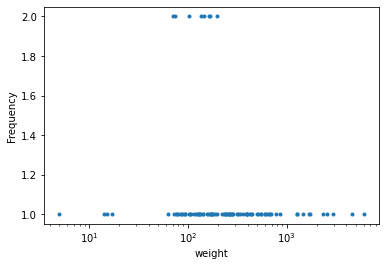

In [141]:
hub_weights = results[results['edge_type'] == 'FOCUS-FOCUS']['weight'].to_list()
counts = Counter(hub_weights)   
# dist = dict(zip(counts.keys(), np.array(list(counts.values()))/len(hub_weights)))
# x = dist.keys()
# y = dist.values()

x, y = zip(*counts.items())
plt.figure(1)   
                                                                                                                                                                                                                                                      
# prep axes                                                                                                                      
plt.xlabel('weight')                                                                                                             
plt.xscale('log')                                                                                                                
# plt.xlim(1, max(x)+1)  
                                                                                                           
plt.ylabel('Frequency')                                                                                                                                                                                                                         
# plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                     # do plot                                                                                                                        
plt.scatter(x, y, marker='.')                                                                                                    
plt.show()

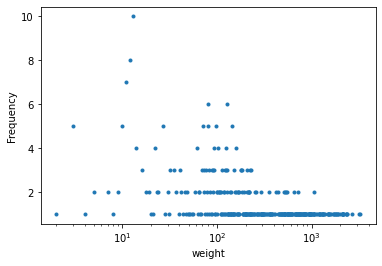

In [140]:
hub_weights = results[results['edge_type'] == 'FOCUS-SPOKE']['weight'].to_list()
counts = Counter(hub_weights)   
# dist = dict(zip(counts.keys(), np.array(list(counts.values()))/len(hub_weights)))
# x = dist.keys()
# y = dist.values()

x, y = zip(*counts.items())
plt.figure(1)   
                                                                                                                                                                                                                                                      
# prep axes                                                                                                                      
plt.xlabel('weight')                                                                                                             
plt.xscale('log')                                                                                                                
# plt.xlim(1, max(x)+1)  
                                                                                                           
plt.ylabel('Frequency')                                                                                                                                                                                                                         
# plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                     # do plot                                                                                                                        
plt.scatter(x, y, marker='.')                                                                                                    
plt.show()

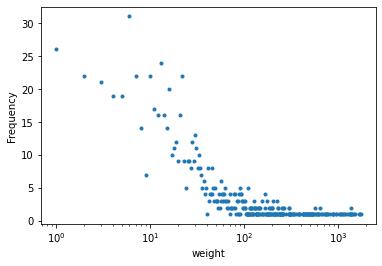

In [142]:
hub_weights = results[results['edge_type'] == 'SPOKE-SPOKE']['weight'].to_list()
counts = Counter(hub_weights)   
# dist = dict(zip(counts.keys(), np.array(list(counts.values()))/len(hub_weights)))
# x = dist.keys()
# y = dist.values()

x, y = zip(*counts.items())
plt.figure(1)   
                                                                                                                                                                                                                                                      
# prep axes                                                                                                                      
plt.xlabel('weight')                                                                                                             
plt.xscale('log')                                                                                                                
# plt.xlim(1, max(x)+1)  
                                                                                                           
plt.ylabel('Frequency')                                                                                                                                                                                                                         
# plt.ylim(1, max(y)+1)                                                                                                             
                                                                                                                                     # do plot                                                                                                                        
plt.scatter(x, y, marker='.')                                                                                                    
plt.show()